In [682]:
%load_ext autoreload
%autoreload 2

import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

import os

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch
torch.set_default_tensor_type(torch.DoubleTensor)

import renyi
import utils
import sxp

from time import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [693]:
os.makedirs('./data/mnist', exist_ok=True)

mnist = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data/mnist', train=True, download=True,))

letters = torch.utils.data.DataLoader(torchvision.datasets.EMNIST('./data/emnist', 'letters', train=True, download=True,))

fashion = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST('./data/fashion', train=True, download=True))

In [705]:
def img_mixture_divergence(mu, nu, alpha, kernel, img_shape=None, use_avg=True):   
    
    Kmu = kernel(mu)
    Knu = kernel(nu)

    if use_avg:
        r = (mu + nu) / 2
        Kr = kernel(r)
        rat1 = Kmu / utils.min_clamp(Kr)
        rat2 = Knu / utils.min_clamp(Kr)
    else:
        rat1 = Kmu / utils.min_clamp(Knu)
        rat2 = Knu / utils.min_clamp(Kmu)
    
    rat1 = utils.min_clamp(rat1)
    rat2 = utils.min_clamp(rat2)
    
    if alpha == 1:
        u = (mu * torch.log(rat1)).sum(dim=-1).sum(dim=-1)
        v = (nu * torch.log(rat2)).sum(dim=-1).sum(dim=-1)

        return (u + v)
    else:
        
        u = (mu * rat1**(alpha-1)).sum(dim=-1).sum(dim=-1)
        u = torch.log(utils.min_clamp(u))

        v = (nu * rat2**(alpha-1)).sum(dim=-1).sum(dim=-1)
        v = torch.log(utils.min_clamp(v))

        return (u + v) / (alpha - 1)

def sample_and_resize(D, img_size, num_samples=1):
    res = []
    for _ in range(num_samples):
        ix = int(np.random.choice(len(D), 1))
        sample_img = D[ix, ...].data.numpy()
        #sample_img = tform(sample_img)[0, ...].data.numpy()
        if img_size != 28:
            sample_img = resize(sample_img, (img_size, img_size), mode='constant')
        sample_img = np.abs(sample_img) / np.abs(sample_img).sum()
        res.append(sample_img)
    return torch.tensor(res).double()

In [710]:
from skimage.transform import resize

img_size = 28#50
# Z = torch.tensor(np.array(list(itertools.product(np.linspace(0, 1, img_size), np.linspace(0, 1, img_size))))).double()
# K = rbf_kernel(torch.cat((Z, Z)),  [0.1], 2).double()
# old_kernel = lambda x: K

[Ygrid, Xgrid] = np.meshgrid(np.linspace(0, 1, img_size), np.linspace(0, 1, img_size))
Kmat = np.exp(-np.abs(Xgrid - Ygrid)**2/(0.04**2))
#Kmat = 1 / (1 + np.abs(Xgrid - Ygrid)**0.01)
Kmat = torch.tensor(Kmat)

img_kernel = lambda x: torch.matmul(torch.matmul(Kmat, x), Kmat)

#plt.imshow(img_kernel(utils.draw_circle(img_size)))

tform = torchvision.transforms.Compose(
                      [torchvision.transforms.ToPILImage(),
                       torchvision.transforms.RandomAffine(10, translate=(0., 0.), scale=(0.5, 1), shear=0, resample=False, fillcolor=0),
                       torchvision.transforms.ToTensor()
                      ])

In [711]:
# plt.imshow(Kmat)
# plt.colorbar()

In [713]:
alpha = 2.

barys = []

data = fashion

for digit in range(0, 10):
    start = time()
    ix = data.dataset.train_labels == digit
    D = data.dataset.train_data[ix].view(-1, 28, 28).float()
    
    # for EMNIST
    #D = data.dataset.train_data[ix].view(-1, 28, 28).transpose(-1, -2).float()
    
    logit_mu = torch.nn.Parameter(torch.rand(1, img_size*img_size))
    temp = torch.nn.Parameter(torch.tensor(1.))

    optimizer = torch.optim.Adam([logit_mu, temp], lr=0.05, amsgrad=False)
    #optimizer = torch.optim.RMSprop([logit_mu, temp], lr=0.05)
    
    for i in range(250):

        optimizer.zero_grad()
        
        mu = torch.softmax(logit_mu /  torch.exp(temp), dim=1).view(1, img_size, img_size) 
        nu = sample_and_resize(D[0:-1, ...], img_size, 32)
        
        l1 = img_mixture_divergence(mu, nu, alpha, kernel=img_kernel, use_avg=True).mean()
        l2 = img_mixture_divergence(mu, mu, alpha, kernel=img_kernel, use_avg=True).mean()
        l3 = img_mixture_divergence(nu, nu, alpha, kernel=img_kernel, use_avg=True).mean()
        
        loss = 2*l1 - l2 - l3 
        
        if i % 50 == 0:
            print("%d - %d - %.4f" % (digit, i, loss.item()))

        if False and i % 200 == 0:
            mu = torch.softmax(logit_mu, dim=1).view(img_size, img_size).data
            plt.figure(figsize=(2, 2))
            plt.imshow(mu, cmap='hot_r');
            plt.show()

        loss.backward()
        optimizer.step()
    
    mu = torch.softmax(logit_mu /  torch.exp(temp), dim=1).view(img_size, img_size)
    barys.append(mu.data)
    
    print('Class time: ', time()-start)

0 - 0 - 0.9811
0 - 50 - 0.2387
0 - 100 - 0.2586
0 - 150 - 0.1540
0 - 200 - 0.2047
Class time:  5.561529636383057
1 - 0 - 1.5115
1 - 50 - 0.1702
1 - 100 - 0.2187
1 - 150 - 0.2297
1 - 200 - 0.2524
Class time:  5.614204406738281
2 - 0 - 0.7770
2 - 50 - 0.2141
2 - 100 - 0.2264


KeyboardInterrupt: 

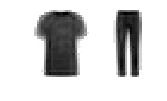

In [714]:
plt.figure(figsize=(1.2*len(barys), 3))
cat_barys = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in barys], dim=1)
plt.imshow(cat_barys, cmap='gray_r')
plt.axis('off')
plt.show()

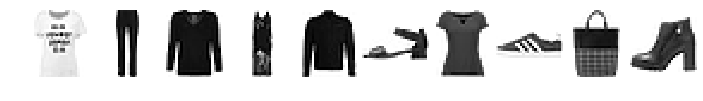

In [690]:
toshow = []
for digit in range(0, 10):
    ix = data.dataset.train_labels == digit
    D = data.dataset.train_data[ix].view(-1, 28, 28).float()
    toshow.append(D[np.random.choice(D.shape[0])])
    
plt.figure(figsize=(12, 2))
#toshow = D[np.random.choice(D.shape[0])] / D[np.random.choice(D.shape[0])].sum() 
plt.imshow(torch.cat(toshow, dim=1).data.numpy(), cmap='gray_r')
plt.axis('off')
plt.show()